## Plot results

The purpose of this notebook is to visualize models' performances singlehandedly and/or with respect to each other's. It expects the selected models to have already gone through training using the `run_exp_script.py` script.

## Imports

In [2]:
%load_ext autoreload
%autoreload 2
import pickle
import glob
import pandas as pd
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt
from utils import plot_utils as plot
from models.build_models import build_model
from datasets.dataset_classes import MSDataset, NLDataset, MSNLDataset
from testing import test
import torch
from sklearn.metrics import r2_score

CKPT_PATH = 'models/checkpoints/'
DATASET   = 'data/dataset_2013+.csv'
# DATASET   = 'data/dataset.csv'
DATA_DIR  = 'data/landsat_7_less/'
# DATA_DIR  = 'data/landsat_7/'
FOLDS     = 'data/dhs_incountry_folds_2013+.pkl'
# FOLDS   = 'data/dhs_incountry_folds_all.pkl'
bg_map = gpd.read_file('data/africa.json')

In [9]:
RESULT_PATH = 'models/results/msnl_*'
result_list = glob.glob(RESULT_PATH)
# Load Results
results = dict()
for i in range(len(result_list)):
    with open(result_list[i], 'rb') as f:
        results[i] = pickle.load(f)
result_list

['models/results/msnl_best_0.pkl', 'models/results/msnl_best__0.pkl']

[]

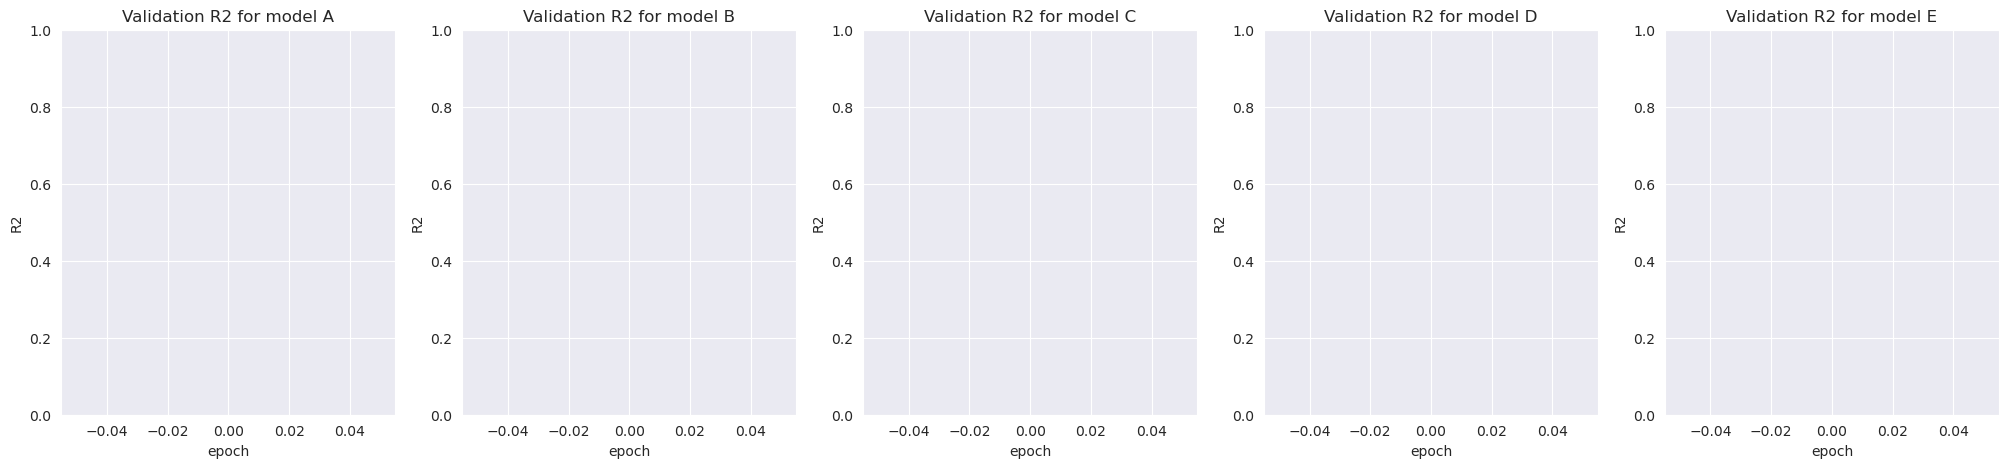

In [5]:
multi_val_dict, val_dataframes = dict(), dict()
for i in results:
    multi_val_dict[i] = plot.extract_crossval_results(results=results[i], var='test_r2', new_var="R2", to_cpu=False)
    val_dataframes[i] = pd.DataFrame.from_dict(multi_val_dict[i])

# Plot preparation
sns.set_palette('pastel')
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,5,figsize=(25, 5))

for fold in ['A','B','C','D','E']:
    x = ord(fold)-ord('A')
    ax[x].set_title(f'Validation R2 for model {fold}')
    for i in results:
        sns.lineplot(ax=ax[x], data=val_dataframes[i][val_dataframes[i].fold==fold], x="epoch", y="R2",legend=True).set(ylim=(0, 1))
plt.plot()

In [ ]:
# dataset with predictions on test sets
save_path='results/ts_test.csv'

model_config_filename = 'configs/ts_gs.json'

df_test = test.main(
    write_path=save_path,
    fold_path=FOLDS,
    network_config_filename=model_config_filename,
    dataset=pd.read_csv(DATASET),
    model_type="ts"
)

In [3]:
save_path='results/ts.csv'
df_test = pd.read_csv(save_path)
df_test = df_test.rename(columns={"wealthpooled": "True Wealth", "predicted_wealth": "Predicted Wealth"})

In [4]:
# Compute R2
df_test= df_test[~df_test['Predicted Wealth'].isna()]
r2_all = r2_score(df_test['True Wealth'], df_test['Predicted Wealth'])
r2_all

0.042806314803081724

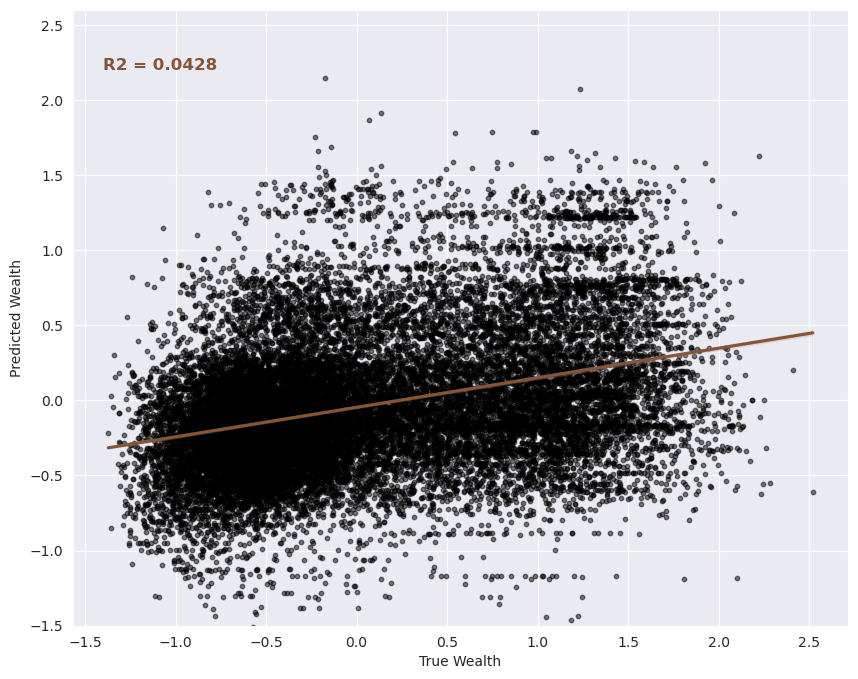

In [5]:
pal = sns.color_palette("copper")
sns.set_style("darkgrid", {'axes.grid' : True})

plt.figure(figsize=(10, 8))
sns.regplot(x="True Wealth", y="Predicted Wealth", data=df_test,x_ci='sd', marker='o', scatter_kws={'alpha':0.5,'color':'black', 's':10}, line_kws={'color':pal.as_hex()[2]}).set_ylim(-1.5, 2.6)
plt.text(-1.4,2.2, 'R2 = ' + str(round(r2_all,4)), fontsize='large', weight='bold', color=pal.as_hex()[2])
plt.show()

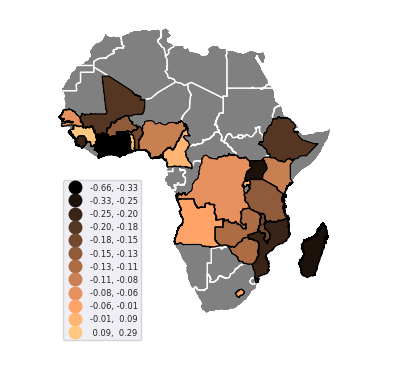

<Figure size 800x1000 with 0 Axes>

In [6]:
plot.country_plot(
    bg_map=bg_map,
    data=df_test,
    cmap='copper',
    bg_color='gray',
    edgecolor='white'
)

sample size: 11874
4426 7448


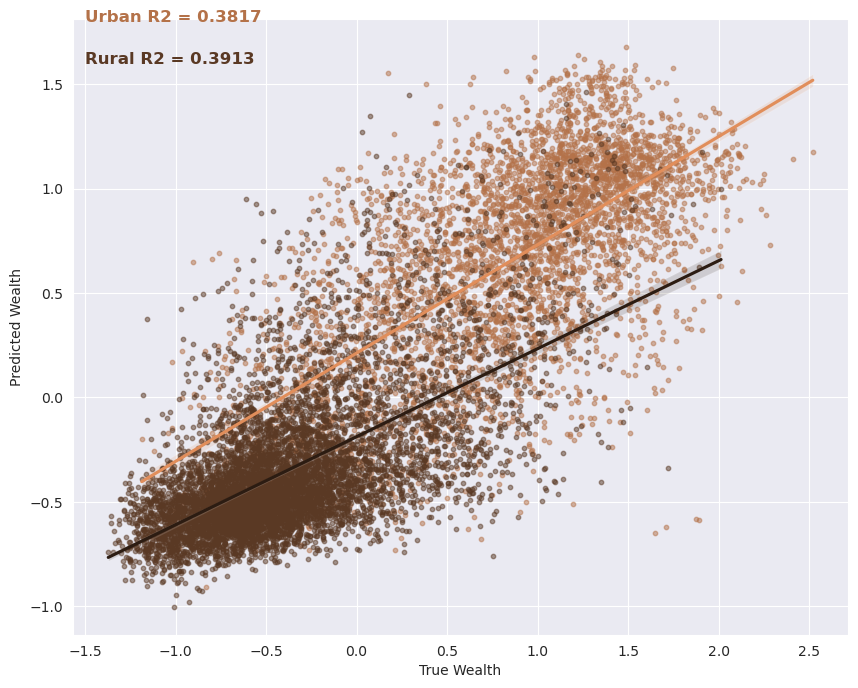

In [45]:
df_test_ur = df_test[df_test['urban_rural']!=-1]
print('sample size:', len(df_test_ur))
df_test_ur = df_test_ur.rename({'urban_rural':'Urban vs Rural'},axis=1)

plot.split_regplot(
    data=df_test_ur,
    col_to_split='Urban vs Rural',
    newcol_name='Urban vs Rural',
    split_val=1.,
    labelinf='Rural',
    labelsup='Urban',
    pal=sns.color_palette("copper"),
    scatter_kws={'alpha':0.2, 's':10},
    line_kws= {'alpha':1., 'linewidth':2}
    )